# NB-AK1: Plot of temperature during historical period for each GCM and obs

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2
pandas 1.2.1


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_met_datasets, resample_data
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize

Last executed: 2021-03-06 08:12:48.812455 by mizukami on casper03


In [ ]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=9, threads=4, memory="108GB",
                  walltime='00:40:00')
cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [ ]:
from dask.distributed import Client
client = Client(cluster)

In [ ]:
client

-------------------------
## Setup 

In [3]:
figSave = True

In [4]:
region = 'AK'
gcms = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
period_hist = slice('1970-01-01', '1999-12-31')
hydro_flux_vars= ['tmin','tmax', 'tmean', 'dtr']

## Load the data

In [5]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_met_datasets(models=gcms, variables=hydro_flux_vars, region=region, parallel=False)

load_monthly_historical_met_datasets
load_monthly_cmip5_met_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


load_obs_dataset


## Compute 30 year seasonal mean for historical period

In [6]:
histo_tair_annual = {}
for name in ['obs', 'gcm']:
    histo_tair_annual[name] = resample_data(histo_data[name].sel(time=period_hist), region='AK', freq='AS').persist().mean('time')

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Plot

In [7]:
# create colormap
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

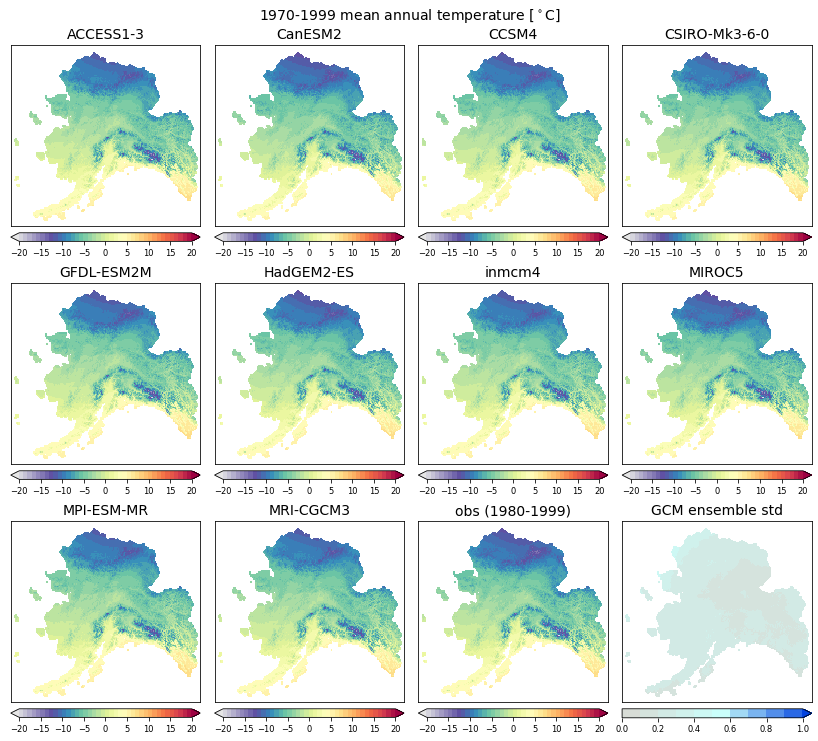

In [16]:
var="tmean"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", pad=0.03)}
kwargs = {'mean': {'levels': 41, 'vmin':-20, 'vmax':20, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 11, 'vmin':0, 'vmax':1,  'cmap':cm['std'],  'extend':'max', **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['obs (1980-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_tair_annual['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        #histo_tair_annual['gcm'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
        histo_tair_annual['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_tair_annual['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
#plt.tight_layout()
fig.suptitle('1970-1999 mean annual temperature [$^\circ$C]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK1_Fig1_annual_mean_{var}_hist.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

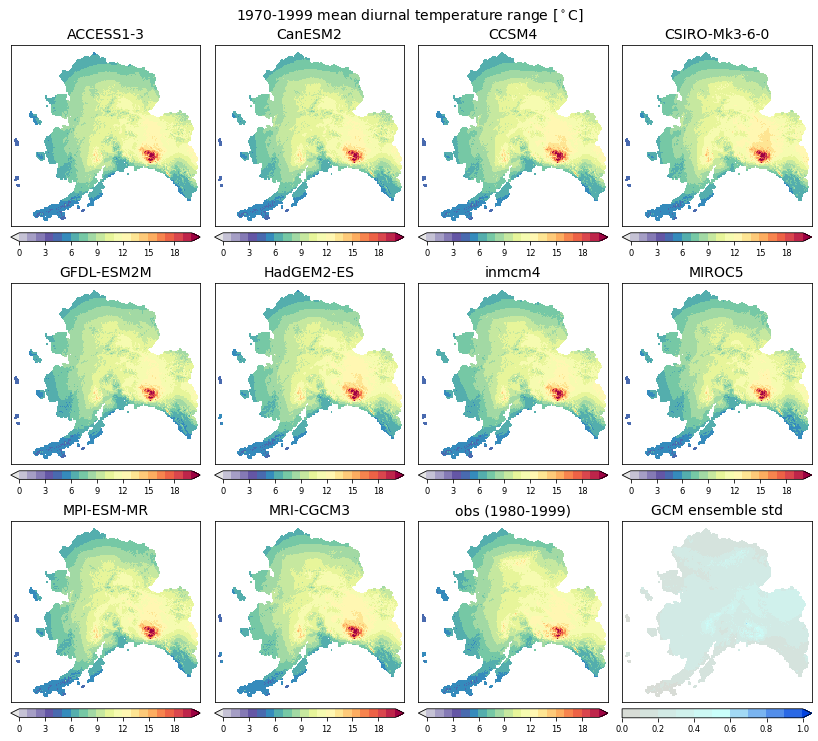

In [17]:
var="dtr"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", pad=0.03)}
kwargs = {'mean': {'levels': 21, 'vmin':0, 'vmax':20, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 11, 'vmin':0, 'vmax':1,  'cmap':cm['std'],  'extend':'max', **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['obs (1980-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_tair_annual['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_tair_annual['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_tair_annual['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('1970-1999 mean diurnal temperature range [$^\circ$C]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK1_Fig2_annual_mean_{var}_hist.png', dpi=300)